In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize

import os
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
sp500_constituents_directory = '../data/sp500'
sample_assets = ['AAPL', 'GE', 'IBM', 'KO', 'MSFT']

In [50]:
ff3 = pd.read_csv('../data/F-F_Research_Data_Factors_daily.CSV')
ff3['date'] = pd.to_datetime(ff3['date'], format='%Y%m%d')
ff3['RF'] = ff3['RF'] / 100
ff3['Mkt-RF'] = ff3['Mkt-RF'] / 100
ff3['SMB'] = ff3['SMB'] / 100
ff3['HML'] = ff3['HML'] / 100
ff3.head()

,date,Mkt-RF,SMB,HML,RF
0,1926-07-01,0.0010,-0.0025,-0.0027,0.00009
1,1926-07-02,0.0045,-0.0033,-0.0006,0.00009
2,1926-07-06,0.0017,0.0030,-0.0039,0.00009
3,1926-07-07,0.0009,-0.0058,0.0002,0.00009
4,1926-07-08,0.0021,-0.0038,0.0019,0.00009


In [51]:
df = pd.DataFrame()
for asset in os.listdir(sp500_constituents_directory):
    asset_df = pd.read_csv(f'{sp500_constituents_directory}/{asset}', index_col=0)
    asset_df['date'] = pd.to_datetime(asset_df['date'])
    if (asset_df['close'] == 0).sum() > 0:
        print(asset)
        asset_df['close'].replace(0, np.nan, inplace=True)
        asset_df['close'] = asset_df['close'].ffill()
    asset_df['return'] = asset_df['close'].pct_change()
    asset_df.dropna(subset=['return'], inplace=True)
    asset_df = asset_df[['date', 'symbol', 'series_id', 'close', 'return']]
    asset_df = pd.merge(asset_df, ff3[['date', 'RF', 'Mkt-RF', 'SMB', 'HML']], on='date')
    if len(df) == 0:
        df = asset_df
    else:
        # concat
        df = pd.concat([df, asset_df])
df['return'] = df['return'] - df['RF']
# Lets only use a random subset of 100 assets from  the data.
df = df[df['date'] > '2015-01-01']
# asset_subset = random.sample(df['symbol'].unique().tolist(), 100) + sample_assets
# df = df[df['symbol'].isin(asset_subset)]
df.head()

KR.csv


,date,symbol,series_id,close,return,RF,Mkt-RF,SMB,HML
6266,2015-01-02,CSCO,58375,27.61,-0.007549,0.0,-0.0012,-0.0061,0.0008
6267,2015-01-05,CSCO,58375,27.06,-0.019920,0.0,-0.0184,0.0033,-0.0068
6268,2015-01-06,CSCO,58375,27.05,-0.000370,0.0,-0.0104,-0.0078,-0.0031
6269,2015-01-07,CSCO,58375,27.30,0.009242,0.0,0.0119,0.0020,-0.0066
6270,2015-01-08,CSCO,58375,27.51,0.007692,0.0,0.0181,-0.0012,-0.0028


In [52]:
# Print the 10 rows with the highest df['return']
df['return_z_score'] = (df['return'] - df['return'].mean()) / df['return'].std()
print(len(df))
df = df[(df['return_z_score'] <= 3) & (df['return_z_score'] >= -3)]
print(len(df))

1230070
1212112


In [53]:
factors = ['Mkt-RF']
factor_betas = []

for asset, asset_data in df.groupby('symbol'):
    X = asset_data[factors]  # Use multiple factors
    X = sm.add_constant(X)  # Add intercept
    y = asset_data['return']
    
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Store betas for each factor along with the expected return
    beta_values = {f'capm_beta': results.params[factor] for factor in factors}
    beta_values['symbol'] = asset
    # Should I be using CAPM expected return?
    beta_values['expected_return'] = asset_data['return'].mean()
    beta_values['std_dev'] = asset_data['return'].std()
    
    factor_betas.append(beta_values)

In [54]:
# Present the sample asset's expected return and beta
factor_betas = pd.DataFrame(factor_betas)
factor_betas[factor_betas['symbol'].isin(sample_assets)]

,capm_beta,symbol,expected_return,std_dev
1,1.104080,AAPL,0.000854,0.016028
199,0.917510,GE,0.000158,0.018137
236,0.751154,IBM,0.000261,0.013199
273,0.491320,KO,0.000312,0.010338
324,1.141194,MSFT,0.000709,0.015130


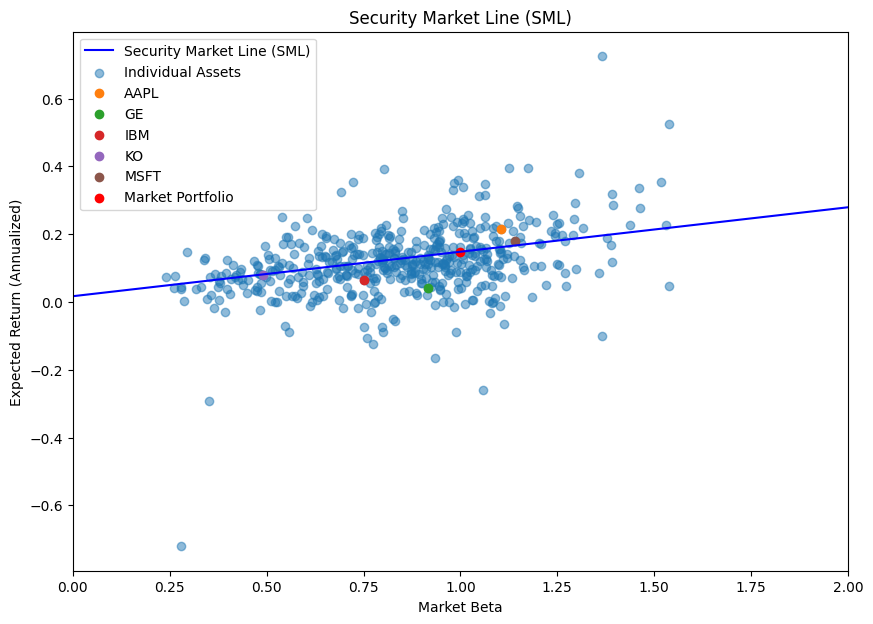

In [55]:
mean_risk_free_rate = df['RF'].mean() * 252
mean_mkt_return = df['Mkt-RF'].mean() * 252
factor_betas['expected_return_ann'] = factor_betas['expected_return'] * 252
factor_betas['capm_expected_return'] = mean_risk_free_rate + factor_betas['capm_beta'] * mean_mkt_return
factor_betas['capm_expected_return'] = factor_betas['capm_expected_return'] * 252
factor_betas['std_dev_ann'] = factor_betas['std_dev'] * np.sqrt(252)

# Plot the Security Market Line directly as a linear equation
plt.figure(figsize=(10, 7))
plt.axline((0, mean_risk_free_rate), slope=mean_mkt_return, color='blue', label="Security Market Line (SML)")

# Scatter plot for individual stocks
plt.scatter(factor_betas['capm_beta'], factor_betas['expected_return_ann'], alpha=0.5, label="Individual Assets")

# Add the sample assets
for asset in sample_assets:
    asset_data = factor_betas[factor_betas['symbol'] == asset]
    plt.scatter(asset_data['capm_beta'], asset_data['expected_return_ann'], label=asset)

# Add the market portfolio
plt.scatter(1, mean_risk_free_rate + mean_mkt_return, color='red', label='Market Portfolio')

plt.xlabel('Market Beta')
plt.ylabel('Expected Return (Annualized)')
plt.title('Security Market Line (SML)')
plt.xlim(0, 2)
plt.legend()

# Show the plot
plt.show()

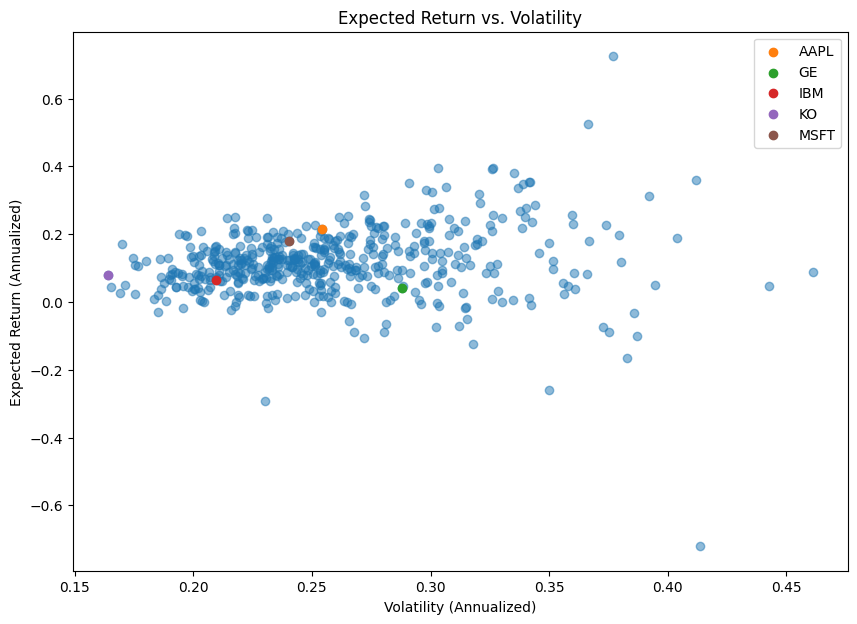

In [56]:
# Lets plot each stock's expected return and volatility
plt.figure(figsize=(10, 7))
plt.scatter(factor_betas['std_dev_ann'], factor_betas['expected_return_ann'], alpha=0.5)
for asset in sample_assets:
    asset_data = factor_betas[factor_betas['symbol'] == asset]
    plt.scatter(asset_data['std_dev_ann'], asset_data['expected_return_ann'], label=asset)
plt.xlabel('Volatility (Annualized)')
plt.ylabel('Expected Return (Annualized)')
plt.title('Expected Return vs. Volatility')
plt.legend()
plt.show()

In [57]:
# Lets get the covariance matrix
#make a returns df which is a pivot table of returns. Columns are symbols and rows are returns
returns = df.pivot_table(index='date', columns='symbol', values='return')
cov_matrix=returns.cov()

In [58]:
def get_portfolio_stats(weights, expected_return, cov_matrix):
    port_return = np.dot(weights, expected_return)
    port_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_std_dev

# Objective function to minimize (portfolio risk given a target return)
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to generate efficient frontier by optimizing for each target return
def efficient_frontier(expected_return, cov_matrix, num_points=100):
    num_assets = len(expected_return)
    target_returns = np.linspace(min(expected_return), max(expected_return), num_points)
    efficient_portfolios = []

    for target_return in target_returns:
        # Constraints: sum of weights = 1, target portfolio return
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Sum of weights = 1
            {'type': 'eq', 'fun': lambda w: np.dot(w, expected_return) - target_return}  # Target return constraint
        ]
        bounds = tuple((0, 1) for _ in range(num_assets))  # Bounds on weights (max 10% per asset)

        # Initial guess for weights (equal weights)
        initial_guess = num_assets * [1. / num_assets]

        # Minimize portfolio risk for given target return
        result = minimize(portfolio_risk, initial_guess, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success:
            portfolio_return, optimized_risk = get_portfolio_stats(result.x, expected_return, cov_matrix)
            efficient_portfolios.append({'Return': portfolio_return, 'Risk': optimized_risk, 'Weights': result.x, 'Sharpe Ratio': (portfolio_return) / optimized_risk})

    return pd.DataFrame(efficient_portfolios)
# Generate the efficient frontier
efficient_frontier_df = efficient_frontier(factor_betas['expected_return_ann'], cov_matrix)

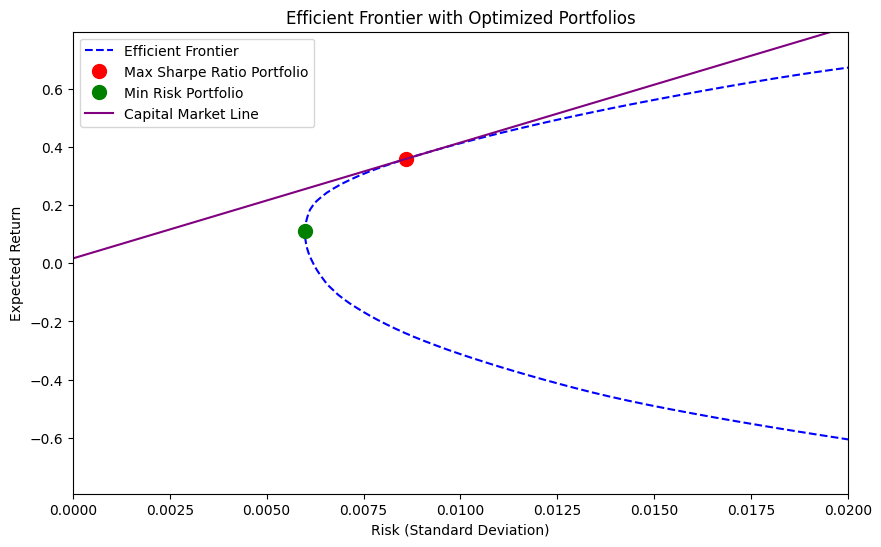

In [59]:
# Highest sharpe portfolio
max_sharpe_idx = efficient_frontier_df['Sharpe Ratio'].idxmax()
max_sharpe_return = efficient_frontier_df.loc[max_sharpe_idx, 'Return']
max_sharpe_risk = efficient_frontier_df.loc[max_sharpe_idx, 'Risk']
max_sharpe_weights = efficient_frontier_df.loc[max_sharpe_idx, 'Weights']

#Min risk portfolio
min_risk_idx = efficient_frontier_df['Risk'].idxmin()
min_risk_return = efficient_frontier_df.loc[min_risk_idx, 'Return']
min_risk_risk = efficient_frontier_df.loc[min_risk_idx, 'Risk']
min_risk_weights = efficient_frontier_df.loc[min_risk_idx, 'Weights']

# Plot the efficient frontier along with simulated portfolios
plt.figure(figsize=(10, 6))
plt.plot(efficient_frontier_df['Risk'], efficient_frontier_df['Return'], 'b--', label='Efficient Frontier')
plt.plot(max_sharpe_risk, max_sharpe_return, 'ro', markersize=10, label='Max Sharpe Ratio Portfolio')
plt.plot(min_risk_risk, min_risk_return, 'go', markersize=10, label='Min Risk Portfolio')
plt.axline((0, mean_risk_free_rate), slope=(max_sharpe_return - mean_risk_free_rate) / max_sharpe_risk, color='purple', label='Capital Market Line')

# Customizations
plt.title('Efficient Frontier with Optimized Portfolios')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.xlim(0, 0.02)
plt.legend()
plt.show()